In [1]:
!git clone https://github.com/Coeze/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 497 (delta 50), reused 13 (delta 13), pack-reused 428 (from 4)
Receiving objects: 100% (497/497), 11.27 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [2]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


# Model Calibration using Genetic Algorithm

This notebook implements a genetic algorithm to optimize the parameters of the forest fire spread model using real fire data from the MTBS dataset. The optimization is based on the Sørensen index (also known as the Dice coefficient), which measures the spatial agreement between simulated and observed burned areas.

In [3]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.4 MB/s eta 0:00:00
  Created wheel for noise: filename=noise-1.2.2-cp311-cp311-linux_x86_64.whl size=56283 sha256=4f141388c34ad12106b6fd2fb6e084f2336fd8b6cd1c74c445340bb574e26dc4
  Stored in directory: /root/.cache/pip/wheels/39/25/2e/af6d1bcc91a8f99af0f651f8718b9ab999720a21c6d4149091
Successfully built noise


In [ ]:
def generate_terrain_simplex(rows, cols, cell_size=30.0, min_elevation=100, max_elevation=1000,
                           octaves=6, persistence=0.5, lacunarity=2.0, scale=100.0, seed=None):
    """
    Generate realistic terrain elevation, slope, and aspect using Simplex noise.

    Parameters:
    - rows, cols: Dimensions of the grid
    - cell_size: Size of each cell in meters
    - min_elevation, max_elevation: Range of elevation values in meters
    - octaves: Number of noise layers to combine (more = more detail)
    - persistence: How much each octave contributes (amplitude multiplier)
    - lacunarity: How frequency increases with each octave
    - scale: Base scale of the noise (higher = more gradual changes)
    - seed: Random seed for reproducibility

    Returns:
    - elevation: 2D numpy array of elevation values
    - slope: 2D numpy array of slope values in degrees
    - aspect: 2D numpy array of aspect values in degrees (0-360, 0=North)
    """

    if seed is not None:
        np.random.seed(seed)

    # Generate elevation using simplex noise
    elevation = np.zeros((rows, cols))

    # For better performance, vectorize the coordinates
    y_coords = np.linspace(0, scale, rows)
    x_coords = np.linspace(0, scale, cols)

    for octave in range(octaves):
        frequency = lacunarity ** octave
        amplitude = persistence ** octave

        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                elevation[i, j] += amplitude * snoise2(
                    y * frequency / scale,
                    x * frequency / scale
                )

    # Normalize to 0-1 range
    elevation_min = elevation.min()
    elevation_max = elevation.max()
    elevation = (elevation - elevation_min) / (elevation_max - elevation_min)

    # Scale to desired elevation range
    elevation = min_elevation + elevation * (max_elevation - min_elevation)

    # Calculate slope and aspect from elevation using gradients
    dy, dx = np.gradient(elevation, cell_size, cell_size)

    # Calculate slope in degrees
    # Slope is the angle of steepest descent
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Calculate aspect in degrees (0-360, clockwise from north)
    # Aspect is the direction of steepest descent
    aspect = np.degrees(np.arctan2(-dx, dy))
    # Convert to 0-360 range (0 = North)
    aspect = np.where(aspect < 0, aspect + 360, aspect)

    return elevation, slope, aspect

# Generate terrain using simplex noise instead of random values
elevation, slope, aspect = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=100,
    max_elevation=1000,
    scale=100.0,
    seed=42
)

# Generate humidity with simplex noise (related to elevation)
_, humidity_base, _ = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=20,
    max_elevation=80,  # 20-80% humidity range
    scale=150.0,  # Larger scale = more gradual changes
    seed=43  # Different seed for variation
)

# Adjust humidity based on elevation (higher elevation = typically lower humidity)
elevation_normalized = (elevation - 100) / 900  # Normalize to 0-1 range
humidity_adjust = -10 * elevation_normalized  # Higher elevations reduce humidity
humidity = np.clip(humidity_base + humidity_adjust, 20, 80)  # Keep in reasonable range

In [4]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import json
from scipy.stats import pearsonr
from deap import base, creator, tools, algorithms

# Import our model from the src directory
from src.model import CA

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Finding Available Fire Data

First, we'll identify the available fire datasets in the data directory that we can use for calibration.

In [5]:
fires = ['alabama', 'arizona']

## Setting Up the Calibration Framework

We'll define functions to evaluate model performance against real fire data using the Sørensen index.

In [6]:
def init_model_from_fire_data(fire, grid_size=(100, 100)):
    """Initialize a CA model from fire data"""
    # Create a new CA model
    model = CA(grid_size=grid_size)
    model.load_terrain_data(slope, aspect, elevation, humidity)
    model.load_mtbs_fire_data(fires[0])


    # Initialize from MTBS data
    success = model.initialise_ndvi_from_data(fire)

    return model if success else None

def evaluate_model_performance(model, simulation_steps=20, params=None):
    """Run a model simulation and evaluate performance against actual fire data"""
    if params:
        # Set model parameters
        model.p0 = params.get('p0', 0.5)
        model.c1 = params.get('c1', 0.5)
        model.c2 = params.get('c2', 0.5)

    # Run the simulation
    history = model.run_simulation(simulation_steps)


    # Compare with actual burned area
    if model.actual_burned_area is not None:
        simulated_burned = (model.grid == 2).astype(int)  # Cells with state 2 are burnt

        # Calculate Sørensen index (Dice coefficient)
        true_positives = np.sum((simulated_burned == 1) & (model.actual_burned_area == 1))
        false_positives = np.sum((simulated_burned == 1) & (model.actual_burned_area == 0))
        false_negatives = np.sum((simulated_burned == 0) & (model.actual_burned_area == 1))

        sorensen = 2 * true_positives / (2 * true_positives + false_positives + false_negatives) if (2 * true_positives + false_positives + false_negatives) > 0 else 0

        return sorensen
    else:
        return 0.0  # No actual data to compare with

## Implementing the Genetic Algorithm for Parameter Optimization

Now we'll implement a genetic algorithm to find the optimal parameters for our fire spread model.

In [14]:
# Define parameter ranges
PARAM_RANGES = {
    'p0': (0.1, 0.9),   # Base ignition probability
    'c1': (0.1, 1.0),   # Wind effect parameter 1
    'c2': (0.1, 1.0)    # Wind effect parameter 2
}

# Define genetic algorithm fitness function
def evaluate_individual(individual, fire_folder, simulation_steps=20):
    """Evaluate fitness of a GA individual (parameter set)"""
    # Convert GA individual to parameter dictionary
    params = {
        'p0': individual[0],
        'c1': individual[1],
        'c2': individual[2]
    }

    # Initialize model
    model = init_model_from_fire_data(fire_folder)
    if not model:
        return (0.0,)  # Return tuple with single value for DEAP

    # Evaluate with these parameters
    sorensen = evaluate_model_performance(model, simulation_steps, params)

    return (sorensen,)  # Return tuple with single value for DEAP

# Setup genetic algorithm
def setup_genetic_algorithm():
    """Setup DEAP genetic algorithm framework"""
    # We want to maximize the Sørensen index
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Register attribute generators
    toolbox.register("attr_p0", random.uniform, PARAM_RANGES['p0'][0], PARAM_RANGES['p0'][1])
    toolbox.register("attr_c1", random.uniform, PARAM_RANGES['c1'][0], PARAM_RANGES['c1'][1])
    toolbox.register("attr_c2", random.uniform, PARAM_RANGES['c2'][0], PARAM_RANGES['c2'][1])

    # Register individual and population creation
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_p0, toolbox.attr_c1, toolbox.attr_c2), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

# Check for DEAP creator reset
if hasattr(creator, "FitnessMax"):
    del creator.FitnessMax
if hasattr(creator, "Individual"):
    del creator.Individual

## Running the Genetic Algorithm

Now we'll run the genetic algorithm to find the optimal parameters for our fire spread model.

Running genetic algorithm optimization for alabama...
Initializing from alabama fire
Loaded burn perimeter successfully
Resampling DNBR data from (299, 287) to (100, 100)
Estimated NDVI from DNBR data
(75, 25)
Loaded burn perimeter shapefile: data/al3039808817220190514/al3039808817220190514_20190513_20190528_burn_bndy.shp
Loaded DNBR raster: data/al3039808817220190514/al3039808817220190514_20190513_20190528_dnbr.tif
Initializing from alabama fire
Loaded burn perimeter successfully
Resampling DNBR data from (299, 287) to (100, 100)
Estimated NDVI from DNBR data
(75, 25)
Loaded burn perimeter shapefile: data/al3039808817220190514/al3039808817220190514_20190513_20190528_burn_bndy.shp
Loaded DNBR raster: data/al3039808817220190514/al3039808817220190514_20190513_20190528_dnbr.tif
Initializing from alabama fire
Loaded burn perimeter successfully
Resampling DNBR data from (299, 287) to (100, 100)
Estimated NDVI from DNBR data
(75, 25)
Loaded burn perimeter shapefile: data/al303980881722019051

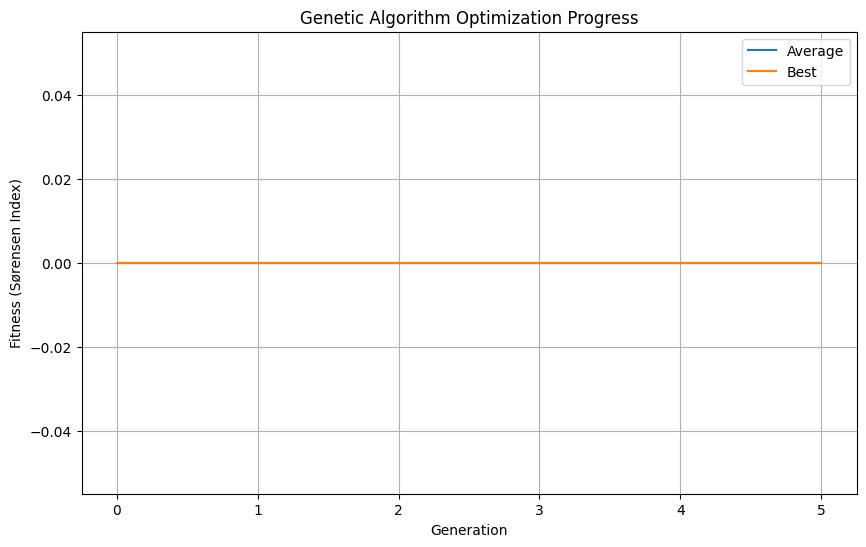

In [15]:
def run_genetic_algorithm(fire_folder, pop_size=30, n_gen=10, simulation_steps=20):
    """Run genetic algorithm to optimize model parameters"""
    print(f"Running genetic algorithm optimization for {fire_folder}...")

    # Setup GA
    toolbox = setup_genetic_algorithm()

    # Register evaluation function with the specific fire dataset
    toolbox.register("evaluate", evaluate_individual, fire_folder=fire_folder, simulation_steps=simulation_steps)

    # Initialize population
    pop = toolbox.population(n=pop_size)

    # Initialize statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Run GA
    hof = tools.HallOfFame(1)  # Keep track of best individual
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_gen,
                                      stats=stats, halloffame=hof, verbose=True)

    # Get best individual
    best_ind = hof[0]
    best_params = {
        'p0': best_ind[0],
        'c1': best_ind[1],
        'c2': best_ind[2]
    }
    best_fitness = best_ind.fitness.values[0]

    print(f"\nOptimization complete.")
    print(f"Best parameters: {best_params}")
    print(f"Best Sørensen index: {best_fitness:.4f}")

    return best_params, best_fitness, logbook

calibration_fire = fires[0]
best_params, best_fitness, logbook = run_genetic_algorithm(
    fire_folder=calibration_fire,
    pop_size=20,  # Small population for demonstration
    n_gen=5,      # Few generations for demonstration
    simulation_steps=30
)

In [10]:
best_params

{'p0': 0.611541438766307, 'c1': 0.12250967970040025, 'c2': 0.34752638653220735}